# Benchmarking more featurizations and ML methods in predicting formation enthalpies of compounds on OQMD dataset 

In this notebook, we'll compare performance of both featurizations and ML algorithms in [Ward (2016)](https://www.nature.com/articles/npjcompumats201628), [Ward (2017)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.024104), [Deml (2016)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.085142), [Faber (2016)](https://arxiv.org/abs/1503.07406) and [Schutt (2014)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118) in predicting formation enthalpies of compounds, $\Delta H_f$.

Note: Run `01.ipynb`, `featurize_ward2016_dataset.ipynb` and `featurize_deml_dataset.ipynb` before this notebook!!

In [1]:
import os
import numpy as np
import pandas as pd
import pymatgen as pmg
import matplotlib.pyplot as plt
import pickle
import time

from matminer.featurizers.structure import SineCoulombMatrix
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lars

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



Import OQMD_ICSD data

In [2]:
y = pd.read_pickle('./y.pkl')

In [3]:
print ("Length of data: ", y.shape)

Length of data:  (31163,)


Initialize dictionary to store cv prediction data

In [4]:
kernels = ['ward2016', 'ward2017', 'deml', 'faber', 'schutt']
cv_test = dict.fromkeys(kernels)
x_train, x_test, y_train, y_test = dict.fromkeys(kernels), dict.fromkeys(kernels), dict.fromkeys(kernels), dict.fromkeys(kernels)

## 1) Faber et al (2016)
Kernel Ridge Regression (KRR) on Sine Coulomb Matrix (SCM) featurization. Since we already have the Coulomb matrix featurized file saved in `01.ipynb`, we can directly load it here.

In [5]:
%%time
X_faber = pickle.load(open("./X_cm.pkl", "rb"))

CPU times: user 48 ms, sys: 164 ms, total: 212 ms
Wall time: 595 ms


Partition into training and testing set (80% training and 20% testing)

In [6]:
x_train['faber'], x_test['faber'], y_train['faber'], y_test['faber'] = train_test_split(X_faber, y, test_size=0.2, shuffle=True)

#### Build ML model (Kernel Ridge Regression)

In [7]:
krr = KernelRidge()
params = {}
params['scm'] = [{'kernel' : ['rbf'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma': [1/2.0/s/s for s in (20000,40000,80000,160000,320000)]},
    {'kernel' : ['laplacian'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma' : [1.0/s for s in (20000,40000,80000,160000,320000)]}]

In [8]:
hpsel = GridSearchCV(krr, params['scm'], cv=KFold(5), refit=True)

Train KRR model using training set data

In [9]:
%%time
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hpsel.fit(x_train['faber'], y_train['faber'])

CPU times: user 18h 45min 33s, sys: 9h 24min 35s, total: 1d 4h 10min 9s
Wall time: 8h 53min 7s


Assign best hyperparameters to model

In [10]:
faber = hpsel.best_estimator_

Prediction data

In [11]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_test['faber'] = cross_val_predict(faber, x_test['faber'], y_test['faber'], cv=KFold(n_splits=5))

## 2) Ward et al (2016)  
RandomForestRegressor on "general purpose" attributes  

In [12]:
df_ward2016 = pd.read_pickle("./ward2016_featurized_data.pkl")

Splitting dataset into training and testing dataset 

In [13]:
X_ward2016 = df_ward2016.drop(['index', 'band_gap', 'delta_e', 'magnetic_moment', 'path', 'stability',
       'structure', 'total_energy', 'volume_pa', 'structure_obj',
       'composition', 'is_ICSD', 'composition_obj'], 1)
y_ward2016 = df_ward2016['delta_e']

In [14]:
x_train['ward2016'], x_test['ward2016'], y_train['ward2016'], y_test['ward2016'] = train_test_split(X_ward2016, y_ward2016, test_size=0.2, shuffle=True)

#### Build ML model (Random Forest Regressor)

In [15]:
param = dict(max_features=(np.linspace(0.1, 1, 10)).tolist())
ward2016 = GridSearchCV(RandomForestRegressor(n_estimators=100),
                        param_grid=param,
                        scoring='neg_mean_squared_error',
                        cv=KFold(5))

Fit using training set

In [16]:
%%time
ward2016 = ward2016.fit(x_train['ward2016'], y_train['ward2016'])

CPU times: user 28min 19s, sys: 6.79 s, total: 28min 26s
Wall time: 28min 25s


Save the best model

In [17]:
ward2016 = ward2016.best_estimator_

Predict testing data using model

In [18]:
cv_test['ward2016'] = cross_val_predict(ward2016, x_test['ward2016'], y_test['ward2016'], cv=KFold(n_splits=5))

## 3) Ward et al (2017)

Random Forest Regressor on Voronoi-tessellation-based crystal representation.

Since the featurization takes a long time, we import the featurized pickle file ready for processing

In [19]:
X_ward2017 = pd.read_pickle('./X_ward.pkl')

Splitting dataset into training and testing data

In [20]:
x_train['ward2017'], x_test['ward2017'], y_train['ward2017'], y_test['ward2017'] = train_test_split(X_ward2017, y, test_size=0.2, shuffle=True)

#### Build ML model (Random Forest Regressor) 

In [21]:
ward2017 = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [22]:
%%time 
ward2017 = ward2017.fit(x_train['ward2017'], y_train['ward2017'])

CPU times: user 10min 40s, sys: 2.65 s, total: 10min 43s
Wall time: 32.7 s


In [23]:
cv_test['ward2017'] = cross_val_predict(ward2017, x_test['ward2017'], y_test['ward2017'], cv=KFold(n_splits=5))

## 4) Deml et al
Stepwise linear regression on composition featurized data. Since featurized data is already saved from running `featurize_deml_dataset.ipynb`, we can load data directly from that. 

In [24]:
df_deml = pd.read_pickle('./deml_featurized_data.pkl')

Remove outliers

In [25]:
original_count = len(df_deml)
df_deml = df_deml[np.logical_and(df_deml['delta_e'] >= -20, df_deml['delta_e'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(df_deml), original_count))

Removed 4/36047 entries


Fill NaN with zero values

In [26]:
df_deml.fillna(value=0, inplace=True)

In [27]:
X_deml = df_deml.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y_deml = df_deml['delta_e']

Partition data into training and testing set

In [28]:
x_train['deml'], x_test['deml'], y_train['deml'], y_test['deml'] = train_test_split(X_deml, y_deml, test_size=0.2, shuffle=True)

#### Build ML model (Stepwise Linear Regression)

In [29]:
deml = GridSearchCV(Lars(), 
                    param_grid=dict(n_nonzero_coefs=(range(10, X_deml.shape[1], 20))),
                    cv=KFold(5))

In [30]:
%%time
deml = deml.fit(x_train['deml'], y_train['deml'])

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.029e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=2.640e-04, with an active set of 33 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.029e-04, with an active set of 11 regressors, and the smallest cholesky pivot el

CPU times: user 18min 37s, sys: 44min 13s, total: 1h 2min 51s
Wall time: 4min 2s


/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.103e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.814e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.



Save the best model

In [31]:
deml = deml.best_estimator_

Predict testing data

In [32]:
cv_test['deml'] = cross_val_predict(deml, x_test['deml'], y_test['deml'], cv=KFold(5))

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.026e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.007e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=8.859e-04, with an active set of 18 regressors, and the smallest cholesky pivot el

## 5) Schutt et al
Kernel Ridge Regression on Partial Radial Distribution Function (PRDF) representation.

In [33]:
X_schutt = pd.read_pickle("./X_prdf.pkl")

Partition data into training and testing set

In [34]:
x_train['schutt'], x_test['schutt'], y_train['schutt'], y_test['schutt'] = train_test_split(X_schutt, y, test_size=0.2, shuffle=True)

#### Build ML model (Kernel Ridge Regression)

In [35]:
schutt = KernelRidge(kernel='laplacian', alpha=0.001, gamma=5e-5)

In [36]:
%%time
schutt = schutt.fit(x_train['schutt'], y_train['schutt'])

CPU times: user 5h 4min 23s, sys: 5min 37s, total: 5h 10min 1s
Wall time: 5h 3min 20s


Predict testing data

In [37]:
cv_test['schutt'] = cross_val_predict(schutt, x_test['schutt'], y_test['schutt'], cv=KFold(5))

## Now we compare these five models 

In [38]:
stats = dict.fromkeys(kernels)
for kernel in stats:
    stats[kernel] = dict.fromkeys(['r2_score', 'mean_absolute_error', 'mean_squared_error'], 0.0)

In [39]:
for kernel in kernels:
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        stats[kernel][scorer] = (getattr(metrics,scorer)(y_test[kernel], cv_test[kernel]))

Plot predictions

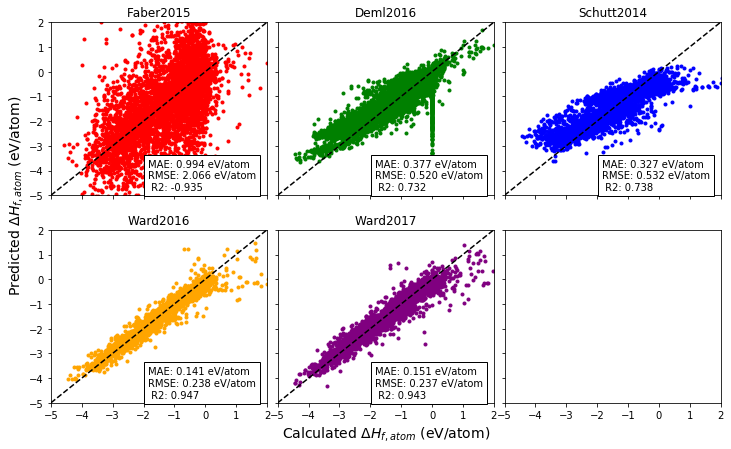

In [40]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0,0].set_xlim([-5, 2])
ax[0,0].set_ylim([-5, 2])

ax[0,0].set_ylabel("Predicted $\Delta H_{f, atom}$ (eV/atom)", fontsize=14, y=0.0)
ax[1,1].set_xlabel("Calculated $\Delta H_{f, atom}$ (eV/atom)", fontsize=14)

ax[0,0].set_title("Faber2015")
ax[0,1].set_title("Deml2016")
ax[0,2].set_title("Schutt2014")
ax[1,0].set_title("Ward2016")
ax[1,1].set_title("Ward2017")

ax[0,0].scatter(y_test['faber'], cv_test['faber'], marker='.', color='r')
ax[0,1].scatter(y_test['deml'], cv_test['deml'], marker='.', color='g')
ax[0,2].scatter(y_test['schutt'], cv_test['schutt'], marker='.', color='b')
ax[1,0].scatter(y_test['ward2016'], cv_test['ward2016'], marker='.', color='orange')
ax[1,1].scatter(y_test['ward2017'], cv_test['ward2017'], marker='.', color='purple')

for i in range(2):
    for j in range(3):
        if (i==1 and j==2):
            pass
        else:
            ax[i,j].plot(ax[i,j].get_xlim(), ax[i,j].get_xlim(), 'k--')

ax[0,0].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['faber']['mean_absolute_error'], np.sqrt(stats['faber']['mean_squared_error']), stats['faber']['r2_score']),
        transform=ax[0,0].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[0,1].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['deml']['mean_absolute_error'], np.sqrt(stats['deml']['mean_squared_error']), stats['deml']['r2_score']),
        transform=ax[0,1].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[0,2].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['schutt']['mean_absolute_error'], np.sqrt(stats['schutt']['mean_squared_error']), stats['schutt']['r2_score']),
        transform=ax[0,2].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[1,0].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['ward2016']['mean_absolute_error'], np.sqrt(stats['ward2016']['mean_squared_error']), stats['ward2016']['r2_score']),
        transform=ax[1,0].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[1,1].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['ward2017']['mean_absolute_error'], np.sqrt(stats['ward2017']['mean_squared_error']), stats['ward2017']['r2_score']),
        transform=ax[1,1].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches((12, 7))
fig.subplots_adjust(wspace=0.05)

Findings: Composition based features used in Ward 2016 paper seems to predict formation enthalpy best, and the training time is reasonably short as compared to Faber2015 and Schutt2014's methods. 